In [1]:
import numpy as np
from scipy.stats import jarque_bera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

In [2]:

Data1 = pd.read_excel('G:\\25国赛\\C题\\附件.xlsx', sheet_name='男胎检测数据')


In [3]:
def perform_jb_test(data, data_name):
    """执行JB检验并打印结果"""
    statistic, p_value = jarque_bera(data)
    print(f"{data_name}的JB检验结果：")
    print(f"JB统计量: {statistic:.4f}")
    print(f"p值: {p_value:.4f}")
    print(f"结论: {'数据不服从正态分布' if p_value < 0.05 else '数据服从正态分布'}\n")


In [4]:
def week_to_day(string):
    normalized = string.replace('W', 'w')
    # 移除可能存在的+号
    cleaned = normalized.replace('+', '')

    # 分割周和天
    parts = cleaned.split('w')

    # 提取周数（处理可能的空字符串情况）
    if parts[0].strip():  # 确保周数部分不为空
        week = int(parts[0])
    else:
        return 0  # 或根据实际需求返回错误值

    # 提取天数（如果存在）
    if len(parts) > 1 and parts[1].strip():
        day = int(parts[1])
    else:
        day = 0

    return week * 7 + day


In [5]:
if '检测孕周' in Data1.columns:
    Data1['检测孕周'] = Data1['检测孕周'].apply(week_to_day)

# print(Data1['检测孕周'].head())

threshold = Data1['GC含量'].quantile(0.05)
Data1_filtered = Data1[Data1['GC含量'] > threshold]
print(f"原始数据量: {len(Data1)}")
print(f"过滤后数据量: {len(Data1_filtered)}")
print(f"删除了 {len(Data1) - len(Data1_filtered)} 条最小的5%数据")
print("过滤后的数据前5行:")
print(Data1_filtered.head())

原始数据量: 1082
过滤后数据量: 1027
删除了 55 条最小的5%数据
过滤后的数据前5行:
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   
5   6  A002  32  149.0  76.0  2023-11-09 00:00:00  自然受孕  20240310       2   

   检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0    83  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
2   141  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3   160  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4    97  ...  0.059230  0.059708     0.380260     0.393618     0.404868   
5   117  ...  0.042401  0.040477     0.377387     0.390282     0.399467   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次

In [7]:
def calculate_spearman_matrix(df):
    """计算多变量间的斯皮尔曼相关系数和p值矩阵"""
    cols = df.columns
    n = len(cols)

    # 初始化系数矩阵和p值矩阵
    corr_matrix = pd.DataFrame(np.ones((n, n)), index=cols, columns=cols)
    p_matrix = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

    # 计算两两变量间的相关性
    for i in range(n):
        for j in range(i+1, n):
            corr, p = spearmanr(df[cols[i]], df[cols[j]])
            corr_matrix.loc[cols[i], cols[j]] = corr
            corr_matrix.loc[cols[j], cols[i]] = corr  # 矩阵对称
            p_matrix.loc[cols[i], cols[j]] = p
            p_matrix.loc[cols[j], cols[i]] = p  # 矩阵对称

    return corr_matrix, p_matrix

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

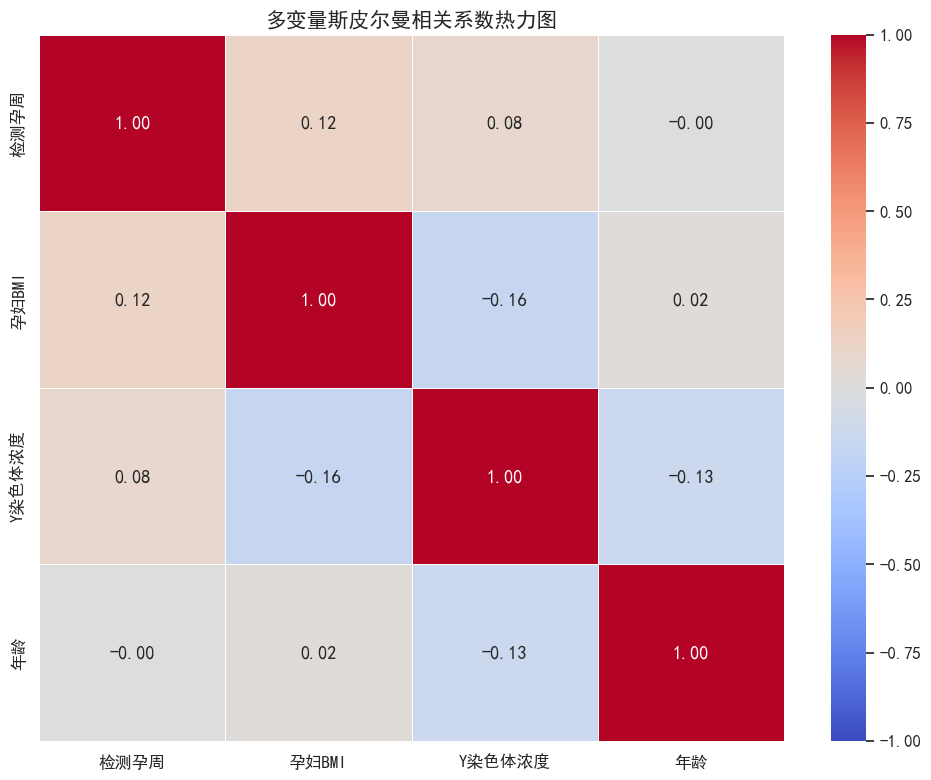


显著相关的变量对（p < 0.05）：
            变量对   相关系数      p值
0    检测孕周-孕妇BMI  0.120  0.0001
1   检测孕周-Y染色体浓度  0.080  0.0108
2  孕妇BMI-Y染色体浓度 -0.162  0.0000
3     Y染色体浓度-年龄 -0.132  0.0000


In [12]:
df = Data1_filtered[['检测孕周','孕妇BMI','Y染色体浓度','年龄']]
corr_matrix, p_matrix = calculate_spearman_matrix(df)
plt.figure(figsize=(10, 8))
# 绘制相关系数热力图
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]  # 包含多种中文字体备选
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.heatmap(
    corr_matrix,
    annot=True,  # 显示系数值
    cmap='coolwarm',  # 颜色主题（红-蓝表示正负相关）
    vmin=-1, vmax=1,  # 颜色范围
    center=0,  # 颜色中心值
    fmt='.2f',  # 系数显示格式
    linewidths=0.5  # 格子线宽度
)
plt.title('多变量斯皮尔曼相关系数热力图', fontsize=15)
plt.tight_layout()
plt.savefig('spearman_correlation_heatmap.png',  # 文件名
            dpi=300,  # 分辨率，300dpi适合大多数场景
            bbox_inches='tight')  # 自动调整边界，避免标题/标签被裁剪
plt.show()

plt.close()  # 关闭画布，释放内存
# 可选：筛选出显著相关的变量对（p < 0.05）
significant_pairs = []
cols = df.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if p_matrix.iloc[i, j] < 0.05:
            significant_pairs.append({
                '变量对': f"{cols[i]}-{cols[j]}",
                '相关系数': round(corr_matrix.iloc[i, j], 3),
                'p值': round(p_matrix.iloc[i, j], 4)
            })

print("\n显著相关的变量对（p < 0.05）：")
print(pd.DataFrame(significant_pairs))

In [41]:
Data1_filtered.to_excel('Data1_WeekToDay.xlsx', index=False)

In [51]:
perform_jb_test(Data1_filtered['检测孕周'], 'JBtest_excel')

JBtest_excel的JB检验结果：
JB统计量: 89.2025
p值: 0.0000
结论: 数据不服从正态分布

